<h1>Sarcasm Detection Model for News Headlines</h1>

<h4>Importing all necessary modules.</h4>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from unidecode import unidecode

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import collections
import re
import os
import warnings
warnings.filterwarnings('ignore')

<h3>Read into DataFrame</h3>

In [2]:
path = "D:/Data Science Projects/Sarcasm in News/Sarcasm_Headlines_Dataset_v2.json" 

In [3]:
df = pd.read_json(path, lines=True)

<h3>EDA</h3>

In [4]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df = df.drop("article_link", axis=1)

In [6]:
df.columns

Index(['is_sarcastic', 'headline'], dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [8]:
df.shape

(28619, 2)

In [9]:
df.isnull().sum()

is_sarcastic    0
headline        0
dtype: int64

In [10]:
df.duplicated().sum()

116

In [11]:
df.drop_duplicates(subset=["headline"], inplace=True)
df.duplicated().sum()

0

In [12]:
df.describe(include="all")

,is_sarcastic,headline
count,28503.000000,28503
unique,NaN,28503
top,NaN,thirtysomething scientists unveil doomsday clo...
freq,NaN,1
mean,0.475459,NaN
std,0.499406,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,1.000000,NaN


In [13]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


<h3>VISUALIZING THE DATA</h3>
<h4>Ploting the is_sarcastic data to analyze positive and negative counts.</h4>

Text(0.5, 1.0, 'Count of sarcastic(1) vs not sarcastic(0)')

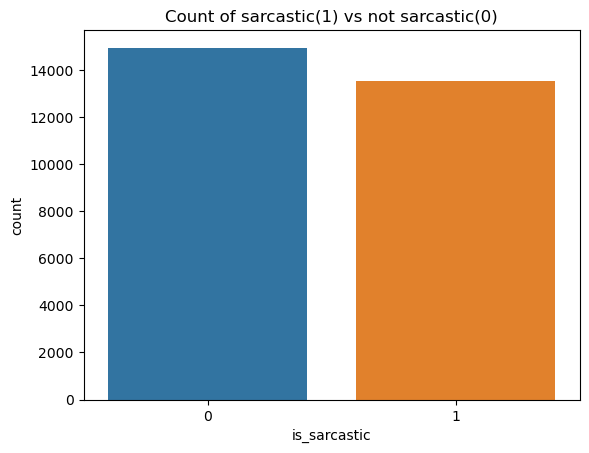

In [14]:
sns.countplot(x="is_sarcastic", data=df)
plt.title("Count of sarcastic(1) vs not sarcastic(0)")

<h4>Let's check the length of the texts.</h4>

Text(0.5, 1.0, 'Not Saecastic Text Length')

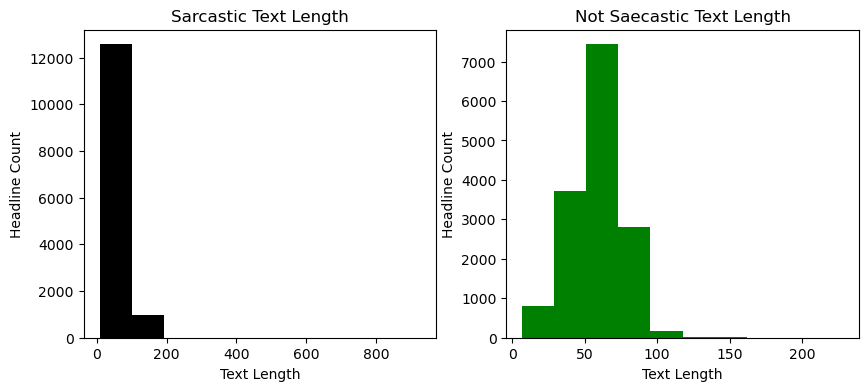

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
text_len = df[df["is_sarcastic"]==1]["headline"].apply(len)
ax1.hist(text_len, color="black")
ax1.set_xlabel("Text Length")
ax1.set_ylabel("Headline Count")
ax1.set_title("Sarcastic Text Length")
text_len = df[df["is_sarcastic"]==0]["headline"].apply(len)
ax2.hist(text_len, color="green")
ax2.set_xlabel("Text Length")
ax2.set_ylabel("Headline Count")
ax2.set_title("Not Saecastic Text Length")

<h4>Let's check the word count of the texts.</h4>

Text(0.5, 1.0, 'Not Sarcastic text word count')

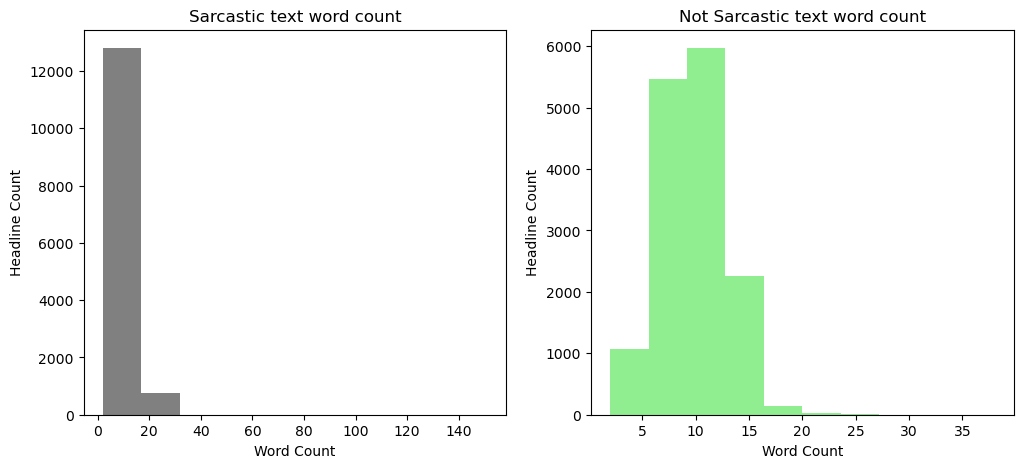

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
text_len = df[df["is_sarcastic"]==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len, color="grey")
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Headline Count")
ax1.set_title("Sarcastic text word count")
text_len = df[df["is_sarcastic"]==0]["headline"].str.split().map(lambda x: len(x))
ax2.hist(text_len, color="lightgreen")
ax2.set_xlabel("Word Count")
ax2.set_ylabel("Headline Count")
ax2.set_title("Not Sarcastic text word count")

Text(0.5, 1.0, 'Not Sarcastic average word length')

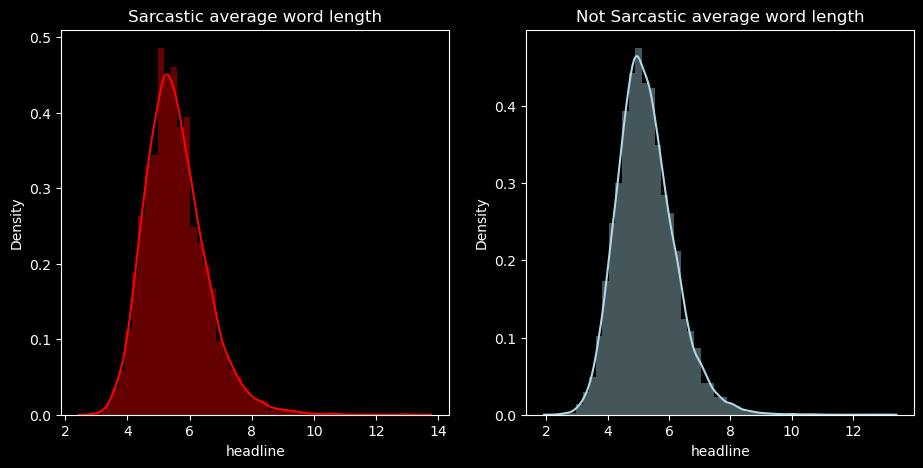

In [17]:
plt.style.use('dark_background')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,5))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic average word length')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='lightblue')
ax2.set_title('Not Sarcastic average word length')

<h2>PREPROCESSING</h2>

<h3>Data Cleaning</h3>

In [18]:
df["headline"]

0        thirtysomething scientists unveil doomsday clo...
1        dem rep. totally nails why congress is falling...
2        eat your veggies: 9 deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word 'strea...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 28503, dtype: object

In [19]:
df['cleaned_headline'] = df['headline'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower()))
df['cleaned_headline'] = df['cleaned_headline'].apply(lambda x: re.sub('\s+', ' ', x).strip())

In [20]:
df["cleaned_headline"]

0        thirtysomething scientists unveil doomsday clo...
1        dem rep totally nails why congress is falling ...
2           eat your veggies deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word stream...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberggate...
28618                   dad clarifies this not a food stop
Name: cleaned_headline, Length: 28503, dtype: object

In [21]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h3>Tokenization, stopword removal, stemming, and joining</h3>

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lawan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

df["final_text"] = df["cleaned_headline"].apply(lambda x: " ".join([stemmer.stem(word) for word in word_tokenize(x.lower()) if word not in stop_words]))

In [24]:
df["final_text"]

0        thirtysometh scientist unveil doomsday clock h...
1        dem rep total nail congress fall short gender ...
2                            eat veggi delici differ recip
3                  inclement weather prevent liar get work
4         mother come pretti close use word stream correct
                               ...                        
28614                      jew celebr rosh hashasha someth
28615    intern affair investig disappoint conspiraci d...
28616          beauti accept speech week came queer korean
28617       mar probe destroy orbit spielbergg space palac
28618                                dad clarifi food stop
Name: final_text, Length: 28503, dtype: object

<h3>TOP 10 MOST USED WORDS BEFORE CLEANING AND PREPROCESSING</h3>

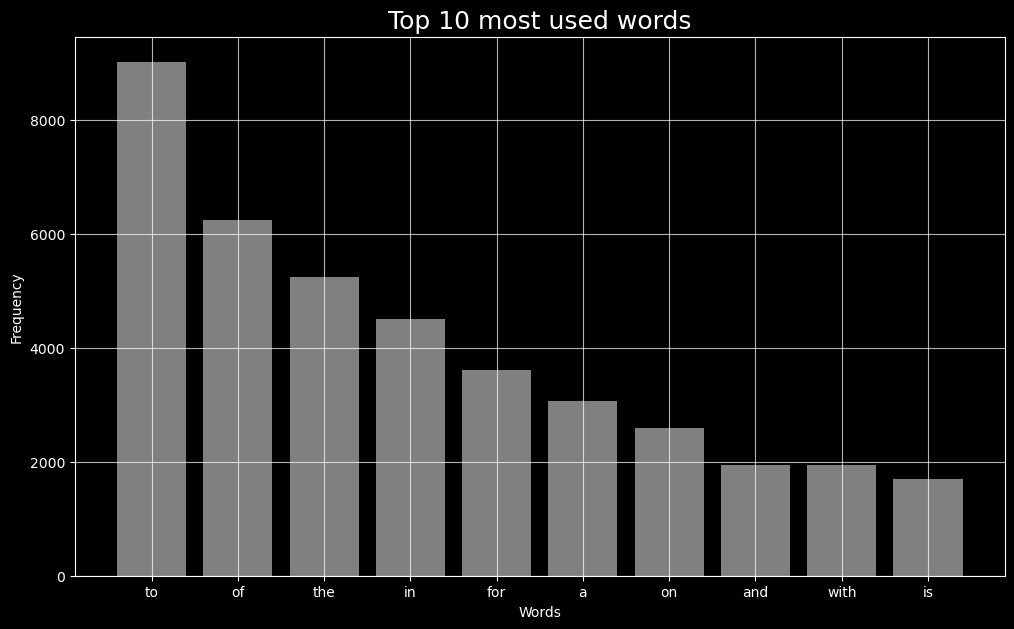

In [25]:
words = []
for text in df["headline"]:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))
plt.style.use("dark_background")
plt.figure(figsize=(12,7))
plt.bar(range(len(top_words)), list(top_words.values()), align="center", color="grey")
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.grid(alpha = 0.7)
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

<h3>TOP 10 MOST USED WORDS AFTER CLEANING AND PREPROCESSING</h3>

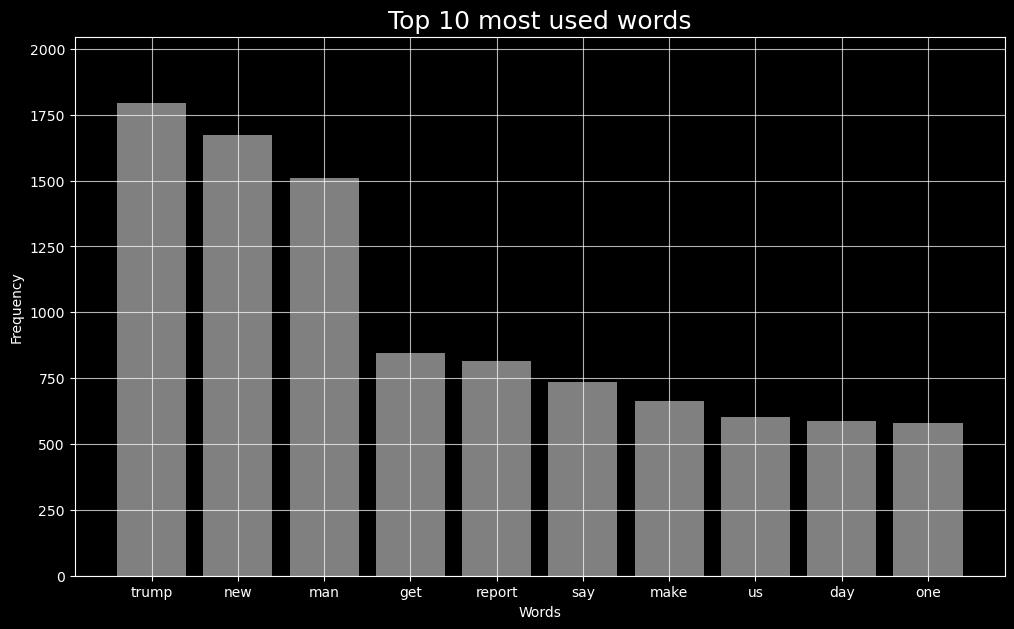

In [26]:
words = []
for text in df["final_text"]:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))
plt.style.use("dark_background")
plt.figure(figsize=(12,7))
plt.bar(range(len(top_words)), list(top_words.values()), align="center", color="grey")
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.grid(alpha = 0.7)
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.yticks(range(0, max(top_words.values()) + 251, 250))
plt.ylim(0, max(top_words.values()) + 250)

plt.show()

<h3>LABEL AND SENTENCES<h3>

In [27]:
labels = np.array(df.is_sarcastic)
sentences = np.array(df.final_text)
print('Number of labels and sentences: ', len(labels), len(sentences))

Number of labels and sentences:  28503 28503


<ul>
    <li><strong>labels</strong> array represents the label (0 or 1) indicating whether a sentence is sarcastic or not.</li>
    <li>Each element in the <strong>sentences</strong> array represents a single preprocessed sentence.</li>
</ul>

In [28]:
sentences

array(['thirtysometh scientist unveil doomsday clock hair loss',
       'dem rep total nail congress fall short gender racial equal',
       'eat veggi delici differ recip', ...,
       'beauti accept speech week came queer korean',
       'mar probe destroy orbit spielbergg space palac',
       'dad clarifi food stop'], dtype=object)

In [29]:
labels

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

<h3>WORD GRAPH</h3>

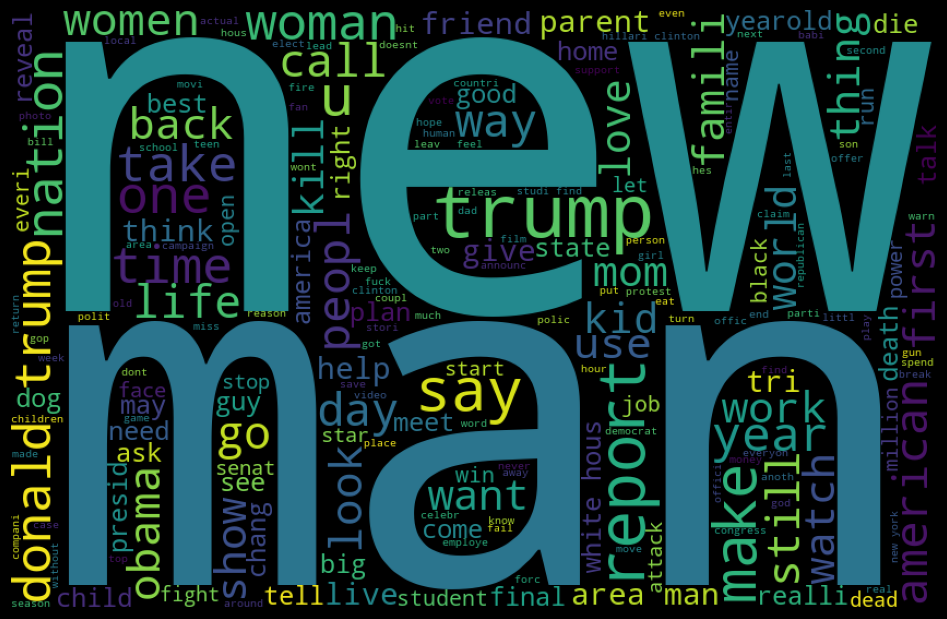

In [30]:
text = " ".join(caption for caption in df["final_text"])
wordcloud = WordCloud(width = 850, height = 550, background_color = "black", min_font_size = 10).generate(text)
plt.figure(figsize=(10,6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<h3>WORD GRAPH FOR SARCASTIC AND NON SARCASTIC HEADLINES</h3>

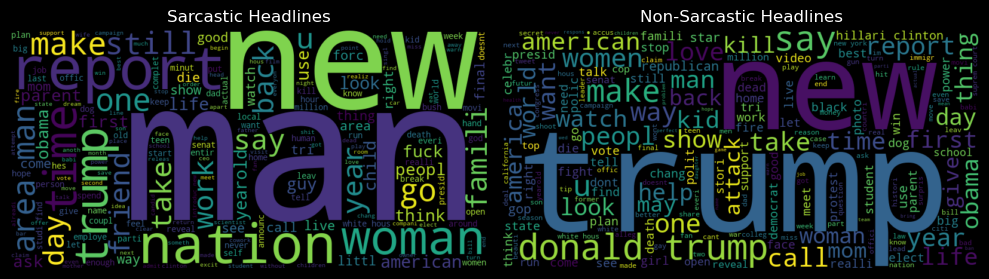

In [31]:
sarcastic_text = " ".join(df[df["is_sarcastic"] == 1]["final_text"])
non_sarcastic_text = " ".join(df[df["is_sarcastic"] == 0]["final_text"])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud_sarcastic = WordCloud(width=800, height=400).generate(sarcastic_text)
plt.imshow(wordcloud_sarcastic, interpolation="bilinear")
plt.title("Sarcastic Headlines")
plt.axis("off")

plt.subplot(1, 2, 2)
wordcloud_non_sarcastic = WordCloud(width=800, height=400).generate(non_sarcastic_text)
plt.imshow(wordcloud_non_sarcastic, interpolation="bilinear")
plt.title("Non-Sarcastic Headlines")
plt.axis("off")
plt.tight_layout()
plt.show()

<h3>Sarcastic and Non Sarcastic Headline Lengths</h3>

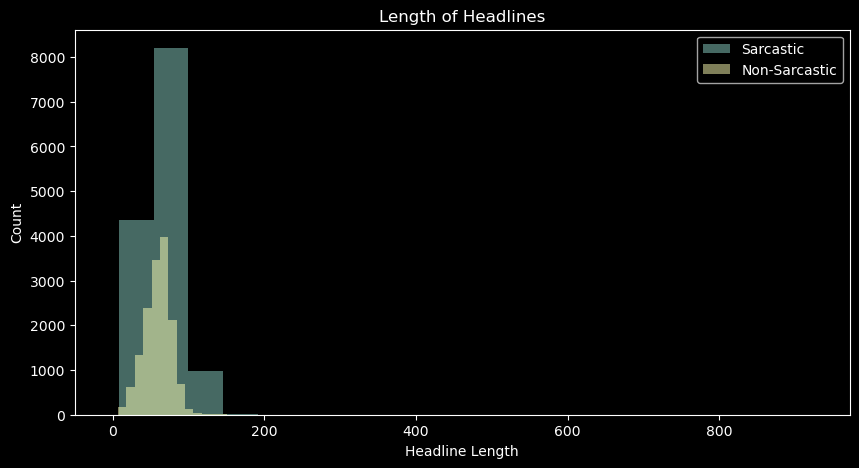

In [32]:
df["headline_length"] = df["headline"].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(df[df["is_sarcastic"] == 1]["headline_length"], bins=20, alpha=0.5, label="Sarcastic")
plt.hist(df[df["is_sarcastic"] == 0]["headline_length"], bins=20, alpha=0.5, label="Non-Sarcastic")
plt.xlabel("Headline Length")
plt.ylabel("Count")
plt.legend()
plt.title("Length of Headlines")
plt.xlim(left=-50)
plt.grid(visible=False)
plt.show()

<h2>TRAIN TEST SPLIT</h2>

In [33]:
x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)
print('Train and Test set distribution: ')
print("x-train: ", len(x_train))
print("y-train: ", len(y_train))
print("x-test: ", len(x_test))
print("y-test: ", len(y_test))

Train and Test set distribution: 
x-train:  22802
y-train:  22802
x-test:  5701
y-test:  5701


In [34]:
vocab_size = 10000
max_length = 32
embedding_dim = 32
padding_type='post'
oov_token = '<OOV>'

In [35]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

<h3>Padding</h3>

In [36]:
train_sequences = tokenizer.texts_to_sequences(x_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type)

test_sequences = tokenizer.texts_to_sequences(x_test)
padded_test_sentences = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type)

In [37]:
embedding_dim = 100
embeddings_index = {}
with open("C:/Users/lawan/Desktop/VIT/IBM Data Science Resources/glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

<h3>Define the model architecture</h3>

In [38]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

<h3>Compile the model</h3>

In [39]:
from tensorflow.keras.optimizers import Adam

In [40]:
learning_rate = 0.001
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           1769100   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,811,405
Trainable params: 42,305
Non-trainable params: 1,769,100
_________________________________________________________________


<h3>Train the model</h3>

In [42]:
history = model.fit(padded_train_sequences, y_train, epochs=10, validation_data=(padded_test_sentences, y_test), batch_size=32)

Epoch 1/10
713/713 [==============================] - 30s 34ms/step - loss: 0.6013 - accuracy: 0.6752 - val_loss: 0.5714 - val_accuracy: 0.7032
Epoch 2/10
713/713 [==============================] - 22s 31ms/step - loss: 0.5247 - accuracy: 0.7418 - val_loss: 0.5336 - val_accuracy: 0.7337
Epoch 3/10
713/713 [==============================] - 22s 30ms/step - loss: 0.4784 - accuracy: 0.7718 - val_loss: 0.5014 - val_accuracy: 0.7536
Epoch 4/10
713/713 [==============================] - 20s 28ms/step - loss: 0.4450 - accuracy: 0.7946 - val_loss: 0.5061 - val_accuracy: 0.7500
Epoch 5/10
713/713 [==============================] - 20s 28ms/step - loss: 0.4152 - accuracy: 0.8073 - val_loss: 0.4831 - val_accuracy: 0.7697
Epoch 6/10
713/713 [==============================] - 19s 27ms/step - loss: 0.3883 - accuracy: 0.8243 - val_loss: 0.4802 - val_accuracy: 0.7720
Epoch 7/10
713/713 [==============================] - 20s 28ms/step - loss: 0.3595 - accuracy: 0.8417 - val_loss: 0.5071 - val_accuracy:

<h3>EVALUATION</h3>

In [43]:
def plot_graphs(history, string):
    plt.style.use("seaborn")
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

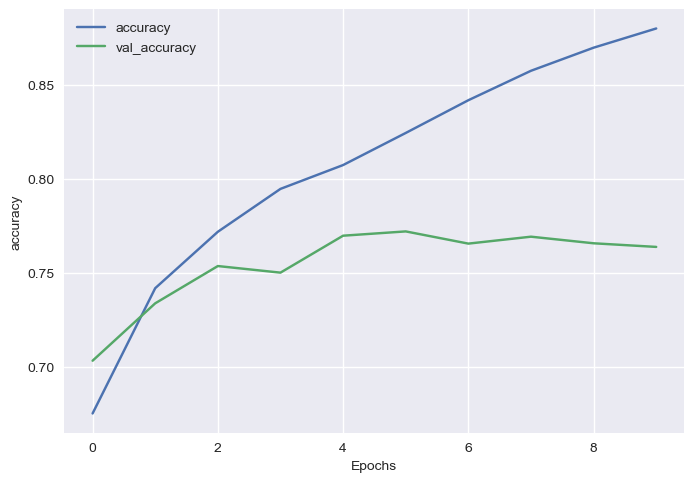

In [44]:
plot_graphs(history, "accuracy")

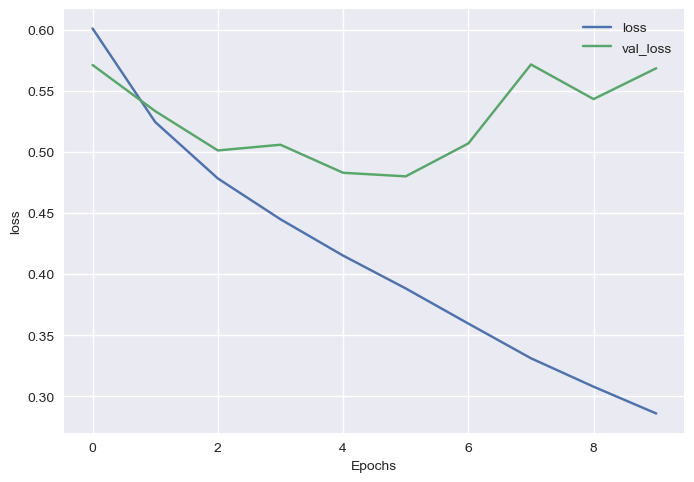

In [45]:
plot_graphs(history, "loss")

In [46]:
print('Accuracy on test set: ', model.evaluate(padded_test_sentences,y_test)[1]*100)

179/179 [==============================] - 2s 13ms/step - loss: 0.5687 - accuracy: 0.7637
Accuracy on test set:  76.37256383895874


In [47]:
preds = model.predict(padded_test_sentences).flatten()
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)
y_predict[:5]

179/179 [==============================] - 3s 12ms/step


[1, 0, 1, 0, 0]

<h2>CLASSIFICATION REPORT</h2>

In [48]:
print(classification_report(y_test, y_predict, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.76      0.81      0.78      3006
    Sarcastic       0.77      0.72      0.74      2695

     accuracy                           0.76      5701
    macro avg       0.76      0.76      0.76      5701
 weighted avg       0.76      0.76      0.76      5701



<h3>Confusion Matrix</h3>

In [49]:
cm = confusion_matrix(y_test,y_predict)
print(cm)

[[2420  586]
 [ 761 1934]]


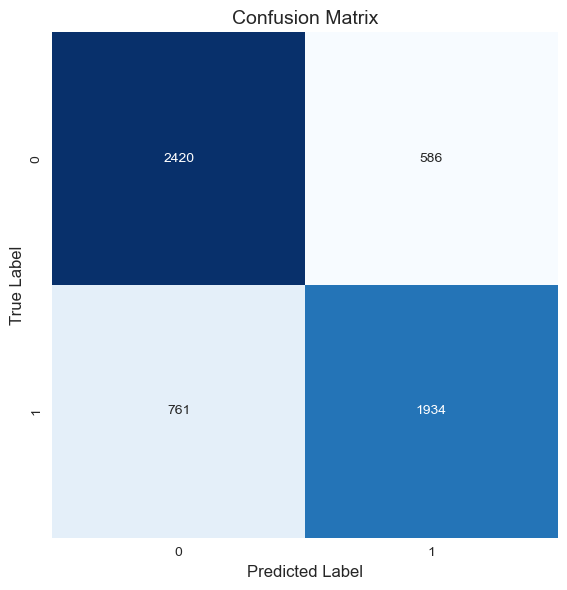

In [50]:
plt.figure(figsize=(8,6))
heatmap = sns.heatmap(cm, square=True, annot=True, cmap="Blues", fmt="d", cbar=False)
heatmap.set_xlabel('Predicted Label', fontsize=12)
heatmap.set_ylabel('True Label', fontsize=12)
heatmap.set_title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

<h2>Using the model on a Sentence</h2>

<h3>Make predictions</h3>

In [51]:
new_sentence = "Groundbreaking Study Reveals That Water is Actually Wet."
# Preprocess the new sentence
new_sequence = tokenizer.texts_to_sequences([new_sentence])
padded_new_sequence = pad_sequences(new_sequence, maxlen=max_length, padding=padding_type)
predictions = model.predict(padded_new_sequence)
labels = ["Not Sarcastic", "Sarcastic"]
predicted_label = labels[int(round(predictions[0][0]))]
print(f"The Sentence Is '{new_sentence}' is: {predicted_label}")

1/1 [==============================] - 0s 55ms/step
The Sentence Is 'Groundbreaking Study Reveals That Water is Actually Wet.' is: Sarcastic


In [55]:
new_sentence = "Scientists Make Significant Progress in Developing a Cure for Cancer"
# Preprocess the new sentence
new_sequence = tokenizer.texts_to_sequences([new_sentence])
padded_new_sequence = pad_sequences(new_sequence, maxlen=max_length, padding=padding_type)
predictions = model.predict(padded_new_sequence)
labels = ['Not Sarcastic', 'Sarcastic']
predicted_label = labels[int(round(predictions[0][0]))]
print(f"The Sentence Is '{new_sentence}' is: {predicted_label}")

1/1 [==============================] - 0s 51ms/step
The Sentence Is 'Scientists Make Significant Progress in Developing a Cure for Cancer' is: Sarcastic


In [53]:
new_sentence = "Clean Science And Technology Allots 8,873 Equity Shares As ESOPs"
# Preprocess the new sentence
new_sequence = tokenizer.texts_to_sequences([new_sentence])
padded_new_sequence = pad_sequences(new_sequence, maxlen=max_length, padding=padding_type)
predictions = model.predict(padded_new_sequence)
labels = ['Not Sarcastic', 'Sarcastic']
predicted_label = labels[int(round(predictions[0][0]))]
print(f"The Sentence Is '{new_sentence}' is: {predicted_label}")

1/1 [==============================] - 0s 63ms/step
The Sentence Is 'Clean Science And Technology Allots 8,873 Equity Shares As ESOPs' is: Not Sarcastic


In [54]:
new_sentence = "Missing Woman Unwittingly Joins Search Party Looking for Herself"
# Preprocess the new sentence
new_sequence = tokenizer.texts_to_sequences([new_sentence])
padded_new_sequence = pad_sequences(new_sequence, maxlen=max_length, padding=padding_type)
predictions = model.predict(padded_new_sequence)
labels = ['Not Sarcastic', 'Sarcastic']
predicted_label = labels[int(round(predictions[0][0]))]
print(f"The Sentence Is '{new_sentence}' is: {predicted_label}")

1/1 [==============================] - 0s 63ms/step
The Sentence Is 'Missing Woman Unwittingly Joins Search Party Looking for Herself' is: Sarcastic


<br>

<h4>Aditya Dadasaheb Lawand</h4>